In [1]:
import statistics
import requests
import spacy
import re
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import colorcet as cc
import matplotlib.pyplot as plt

C:\Users\PC-Usuario\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\PC-Usuario\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\PC-Usuario\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\PC-Usuario\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("db_completa.csv", index_col="Unnamed: 0")

## Centralizados

Nos enfocamos en las dependencias centralizadas ya que son las que tienen mayor homogeneidad en sus descripciones.

In [3]:
centralizados = df[df["centralizado"] == True]

Vectorizamos las descripciones mediante TF-IDF, luego mido la similaridad coseno entre todas las vectorizaciones.

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold

corpus = list(centralizados["proc_text"].astype(str))

vectorizer = TfidfVectorizer(ngram_range=(1, 3))
model = vectorizer.fit_transform(corpus)
model = normalize(model, axis=1, norm="max")
model = VarianceThreshold(threshold=1e-3).fit_transform(model)

similarity_kernel = cosine_similarity(model)

tf_idf = pd.DataFrame(similarity_kernel, index=centralizados["organismo_ente"], columns=centralizados["organismo_ente"])

## Clusterización y visualizaciones

Ahora mediante t-SNE reducimos la dimensionalidad de los vectores para poder graficarlos. Además mediante HDBSCAN identificamos los principales clusters y coloreamos cada dependencia en base a su cluster de pertenencia.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import random

random.seed(123)
fmd = tf_idf
## Si t-SNE tarda mucho se puede hacer una primera reducción mediante SVD
#svd = TruncatedSVD(n_components=8, n_iter=200, random_state=42)
#svd.fit(fmd.T)
X_embedded = TSNE(n_components=2,random_state=123).fit_transform(tf_idf.T)

In [21]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
cluster_labels_orig = clusterer.fit_predict(tf_idf)

In [22]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
cluster_labels = clusterer.fit_predict(X_embedded)
data = {'x': X_embedded[:, 0],
        'y': X_embedded[:, 1],
       'cluster': cluster_labels,
       'cluster_orig': cluster_labels_orig,
       'name':tf_idf.index}
  
# Create DataFrame
df = pd.DataFrame(data)



In [23]:
palette = sns.color_palette(cc.glasbey, n_colors=14)
clusters = {3:'seguridad',1:'Unidad asesores',5:'trabajo', 6:'secretaria administrativa',2:'ciencia y tec',10:'transporte',
 0:'salud',4:'educación',9:'defensa',-1:'resto',11:'economía-desarrollo-agri',12:'territorial',8:'inclusión',7:'administrativa'}
df['cluster_label'] = df['cluster_orig'].apply(lambda x: clusters[x])

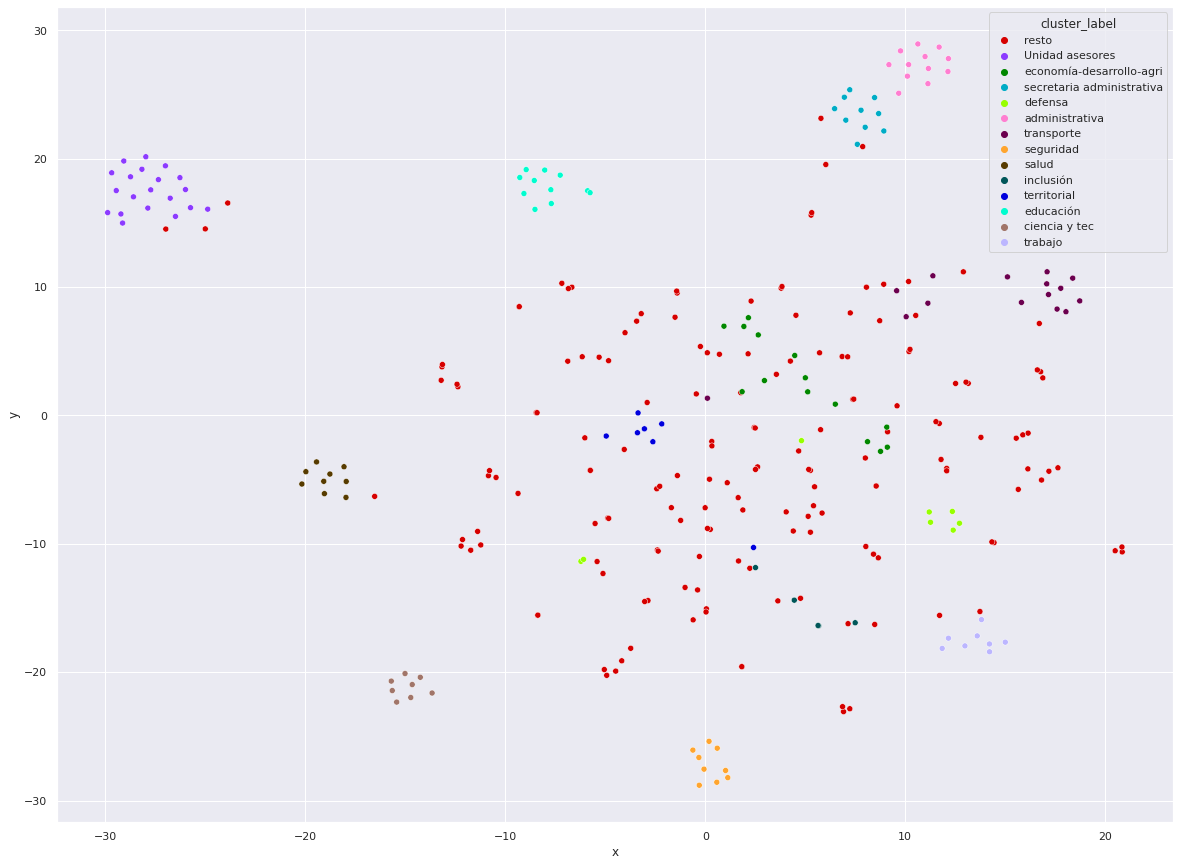

In [10]:
import colorcet as cc
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20,15)})
sns.set_style("white")
#palette=['black','#B5E0EA','#213AA9','#848279','#AFA36E','#FFD900','#7D1B9C','#5D896F','#D3D3E0','#9C9CBC','#FF9750','#E27124','#7BB5C4','#FBB5F5']
plt.figure(dpi=150)

sns.scatterplot(data=df, x="x", y="y", hue="cluster_label",  palette=palette)

plt.savefig('clusters.png')


Visualización de un cluster en particular

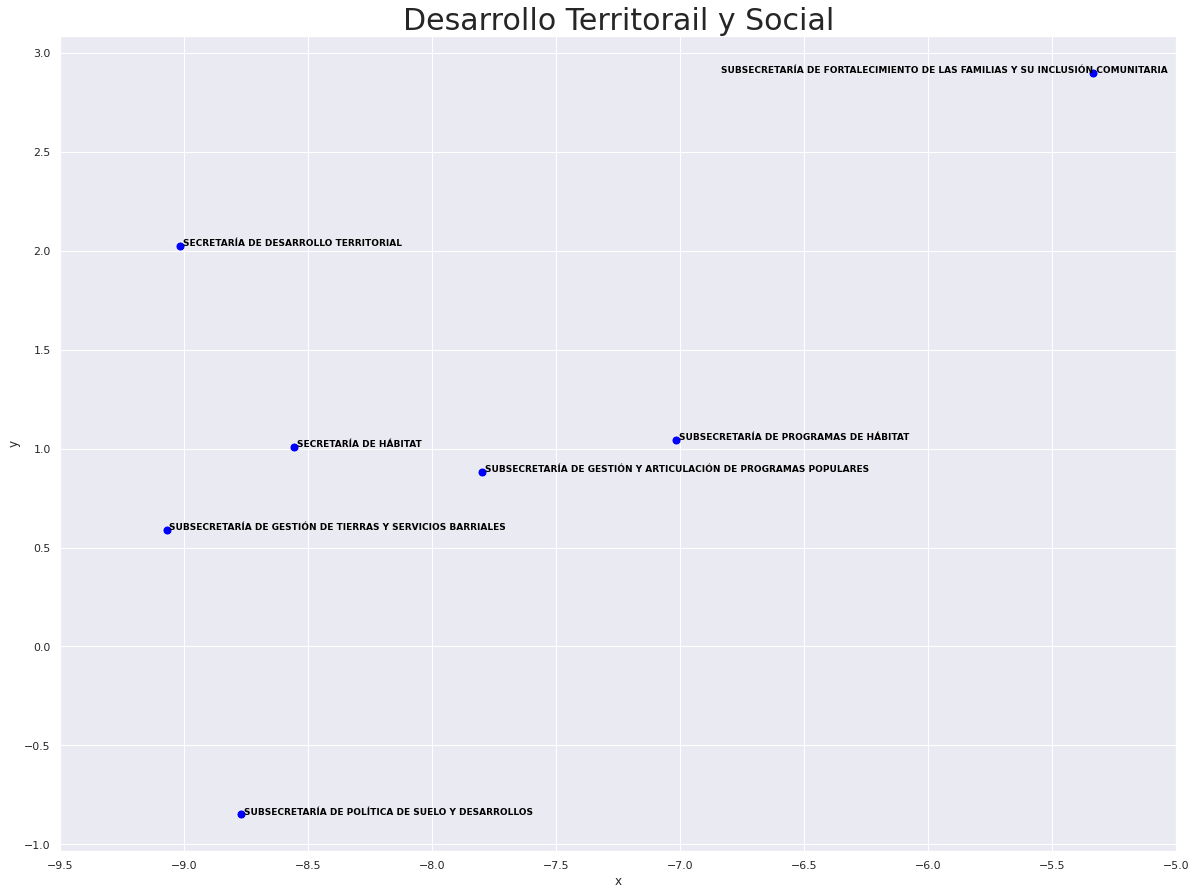

In [25]:
sns.set(rc={'figure.figsize':(20,15)})
territorial = df[(df['cluster_label']=='territorial')]
territorial = territorial.reset_index()
p1 = sns.scatterplot(data=territorial, x="x", y="y",  color='blue', s=80)
plt.title('Desarrollo Territorail y Social', fontsize=30)

plt.xlim([-9.5, -5])

for line in range(0,territorial.shape[0]):
        if (territorial.x[line] > -6):
            p1.text(territorial.x[line]-1.5, territorial.y[line], 
             territorial.name[line], horizontalalignment='left', 
             size=9, color='black', weight='semibold')
        else:
             p1.text(territorial.x[line]+0.01, territorial.y[line], 
             territorial.name[line], horizontalalignment='left', 
             size=9, color='black', weight='semibold')
        
plt.savefig('cluster_zoom_territorial.png')

In [39]:
centralizados.to_csv('centralizados_con_cluster.csv')